<a href="https://colab.research.google.com/github/johnnysDeu/Thesis/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=jztwpsIzEGc

Building a CNN from scratch with any image dataset

!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
#!pip install "tensorflow<2.11"

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#!pip install torchvision

In [4]:

#!pip list
import torch

In [5]:
#!nvidia-smi

In [6]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [7]:
# add headings with ##(space) on the markdowns

In [8]:
#!pip install tensorflor keras

In [9]:
import tensorflow as tf
import os

In [10]:
!nvidia-smi

Wed Apr 24 09:39:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   59C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
#! nvidia-smi

In [14]:
#!pip install opencv-python

## Imports

In [15]:
import tensorflow as tf
import os
import cv2
import imghdr

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import numpy as np
from matplotlib import pyplot as plt

In [18]:
Current_dir = os.getcwd()
Current_dir

'/content'

In [19]:
path = '/content/drive/MyDrive/Colab Notebooks/Thesis/data'
os.chdir(path)

In [20]:
Current_dir = os.getcwd()
Current_dir

'/content/drive/MyDrive/Colab Notebooks/Thesis/data'

In [21]:
data_dir='data'
os.listdir(data_dir)

['Sample_images', 'Ads']

In [22]:
#os.listdir(os.path.join(data_dir,'Ads'))

In [23]:
imgTest= cv2.imread(os.path.join('data','Ads','converted_iframe_9_AD.jpg'))

In [24]:
type(imgTest)

numpy.ndarray

In [25]:
#imgTest.shape

In [26]:
#plt.imshow(imgTest)

In [27]:
#plt.imshow(cv2.cvtColor(imgTest, cv2.COLOR_BGR2RGB))
#plt.show()

# Load Data

In [28]:
#tf.data.Dataset??

In [29]:
#tf.keras.utils.audio_dataset_from_directory??

In [30]:
data=tf.keras.utils.image_dataset_from_directory('data', batch_size=32)

Found 15084 files belonging to 2 classes.


In [31]:
data_iterator=data.as_numpy_iterator()


In [32]:
batch=data_iterator.next()


In [33]:
len(batch) # batch contain 2 items, the image batch[0] and the label batch[1]

2

In [34]:
batch[0].shape # images are numpy arrays

(32, 256, 256, 3)

In [35]:
batch[1] # labels

array([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1], dtype=int32)

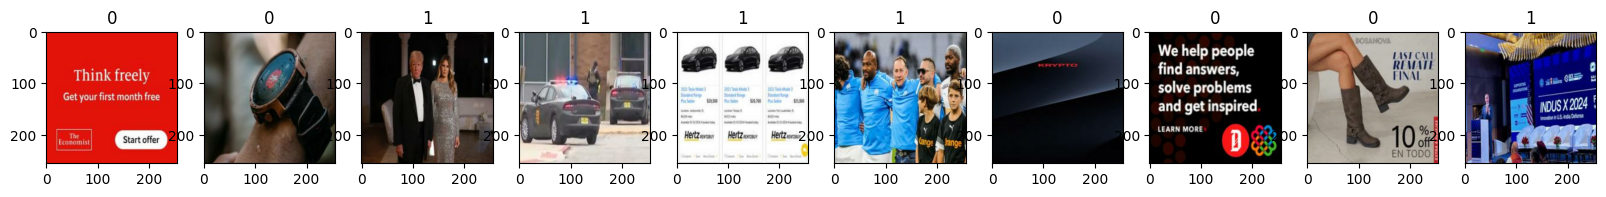

In [36]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20)) # class 1= simple image, class 0 = Ad
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

From the above plot, we see how the function assigns the classes (this may change from run-to-run):

simple image = 1 <br>
Ad = 0

## Preprocess data

In [37]:
print(batch[0].max()) # our pixels are between values 0 and 255. we will scale them to be between 0 and 1

255.0


In [38]:
#batch[0] / 255

In [39]:
scaled= data.map(lambda x,y: (x/255, y)) # as we load a batch from the pipeline, we scale them on the go

In [40]:
#scaled.as_numpy_iterator().next()

In [41]:
scaled_iterator=scaled.as_numpy_iterator()

In [42]:
batch = scaled_iterator.next()

In [43]:
batch[0].max()

1.0

In [44]:
#scaled.as_numpy_iterator().next()

# Split Data

In [45]:
#len(scaled)
len(data)

472

In [46]:
train_size = int(len(scaled)*.7)# batch size 32
val_size = int(len(scaled)*.2) #
test_size = int(len(scaled)*.1) #

In [47]:
print(f'Train Size: {train_size}, Val Size:{val_size}, Test Size: {test_size}')


Train Size: 330, Val Size:94, Test Size: 47


In [48]:
train = scaled.take(train_size)
val = scaled.skip(train_size).take(val_size)
test = scaled.skip(train_size+val_size).take(test_size)

In [49]:
#train.as_numpy_iterator().next()[0]

In [50]:
#batch[0]

In [51]:
len(train)

330

# Model

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten ,Dropout, BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam, Adagrad

In [53]:
SEED = 42 # to always get same dropout and shuffle

In [54]:
def allcnn(weights=None):
    model = Sequential()
    model.add(Conv2D(32, (3,3), 1, padding = 'same', activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    #model.add(Dropout(0.2, seed=SEED))

    model.add(Conv2D(64, (3,3), 1, padding = 'same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    #model.add(Dropout(0.2, seed=SEED))

    model.add(Conv2D(128, (3,3), 1, padding = 'same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    #model.add(Dropout(0.2, seed=SEED))

    model.add(Conv2D(128, (3,3), 1, padding = 'same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.2, seed=SEED))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.2, seed=SEED))
    model.add(Dense(1, activation='sigmoid'))

        # load the weights
    if weights:
        model.load_weights(weights)

    # return model
    return model

In [55]:
# build model
model = allcnn()

In [56]:
# define hyper parameters
learning_rateSGD = 0.01
LEARNING_RATE = 0.001
weight_decay = 1e-6
momentum = 0.9
beta1 = 0.9
beta2 = 0.999
epsilon=1e-07
RHO = 0.9

In [57]:
sgd = SGD(learning_rate=learning_rateSGD, weight_decay=weight_decay, momentum=momentum, nesterov=True)

rmsprop = RMSprop(learning_rate=LEARNING_RATE, rho=RHO, momentum=momentum, epsilon=epsilon, centered=False)

adam = Adam(learning_rate=LEARNING_RATE, beta_1=beta1, beta_2=beta2, epsilon=epsilon)


In [58]:
model.compile(optimizer = 'Adagrad', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                        

# Train

In [60]:
hist = model.fit(train, epochs=30, validation_data=val)

Epoch 1/30
330/330 [==============================] - 637s 2s/step - loss: 0.4359 - accuracy: 0.8112 - val_loss: 0.5318 - val_accuracy: 0.7500
Epoch 2/30
330/330 [==============================] - 36s 109ms/step - loss: 0.2499 - accuracy: 0.9054 - val_loss: 0.2831 - val_accuracy: 0.8939
Epoch 3/30
330/330 [==============================] - 36s 108ms/step - loss: 0.1868 - accuracy: 0.9339 - val_loss: 0.2616 - val_accuracy: 0.9069
Epoch 4/30
330/330 [==============================] - 36s 107ms/step - loss: 0.1451 - accuracy: 0.9509 - val_loss: 0.2609 - val_accuracy: 0.8996
Epoch 5/30
330/330 [==============================] - 36s 108ms/step - loss: 0.1236 - accuracy: 0.9612 - val_loss: 0.2488 - val_accuracy: 0.9079
Epoch 6/30
330/330 [==============================] - 37s 110ms/step - loss: 0.1003 - accuracy: 0.9716 - val_loss: 0.2445 - val_accuracy: 0.9122
Epoch 7/30
330/330 [==============================] - 36s 108ms/step - loss: 0.0817 - accuracy: 0.9806 - val_loss: 0.2464 - val_accu

In [61]:
Current_dir = os.getcwd()
Current_dir

'/content/drive/MyDrive/Colab Notebooks/Thesis/data'

In [62]:
model.save(os.path.join('models','ad_classifier_first_medium40_Model.keras'))

In [63]:
val_acc_per_epoch = hist.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 28


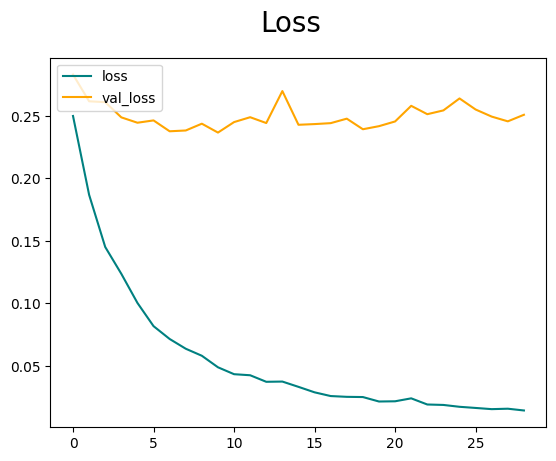

In [64]:
fig = plt.figure()
plt.plot(hist.history['loss'][1:], color='teal', label='loss')
plt.plot(hist.history['val_loss'][1:], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

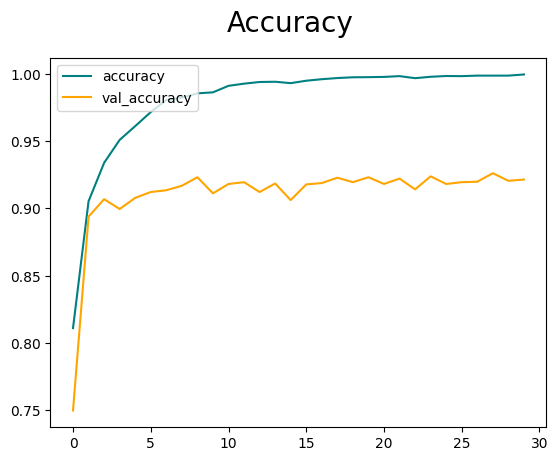

In [65]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate

In [66]:

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [67]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [68]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    print(f'Precision: {pre.result()}, Recall:{re.result()}, Accuracy: {acc.result()}')

1/1 [==============================] - 0s 200ms/step
Precision: 0.8888888955116272, Recall:0.9411764740943909, Accuracy: 0.90625
1/1 [==============================] - 0s 31ms/step
Precision: 0.8918918967247009, Recall:0.970588207244873, Accuracy: 0.921875
1/1 [==============================] - 0s 30ms/step
Precision: 0.9259259104728699, Recall:0.9803921580314636, Accuracy: 0.9479166865348816
1/1 [==============================] - 0s 31ms/step
Precision: 0.9041095972061157, Recall:0.970588207244873, Accuracy: 0.9296875
1/1 [==============================] - 0s 31ms/step
Precision: 0.9120879173278809, Recall:0.954023003578186, Accuracy: 0.925000011920929
1/1 [==============================] - 0s 31ms/step
Precision: 0.8981481194496155, Recall:0.9509803652763367, Accuracy: 0.9166666865348816
1/1 [==============================] - 0s 31ms/step
Precision: 0.8951612710952759, Recall:0.9487179517745972, Accuracy: 0.9151785969734192
1/1 [==============================] - 0s 38ms/step
Precisio

# Extra Testing on Unseen Data

In [69]:
import cv2

In [70]:
Current_dir = os.getcwd()
Current_dir
os.chdir('..')

In [71]:
#img = cv2.imread('sim.jpg')
#img= cv2.imread(os.path.join('testData','4.png')) # s (246).jpg, 9.png, 4.png, s (481).jpg
img= cv2.imread(os.path.join('unseen data','folder_5_main_12.jpg')) #
#img

In [72]:
len(img)


450

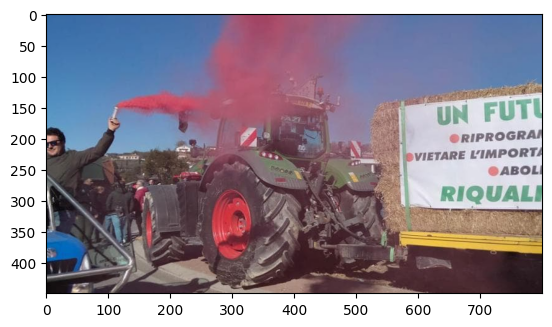

In [73]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [74]:
resize = tf.image.resize(img, (256,256))
#plt.imshow(resize.numpy().astype(int))
#plt.show()

In [75]:
resize.shape

TensorShape([256, 256, 3])

In [76]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [77]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 361ms/step


array([[0.98440856]], dtype=float32)

simple image = 1 <br>
Ad = 0

In [78]:
#class 1= simple img, class 0 = Ad

if yhat > 0.5:
    print(f'Predicted Simple Image')
else:
    print(f'Predicted Ad')

Predicted Simple Image


# Loading the model

In [81]:
from keras.models import load_model
import keras

In [83]:
loaded_model = keras.saving.load_model(os.path.join('models',"ad_classifier_first_small_Model.keras"))
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                        

Check also the following article https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

Keras Tuner : https://www.tensorflow.org/tutorials/keras/keras_tuner

Example model : https://www.tensorflow.org/tutorials/images/classification



# Appling a Pre-trained CNN on our Dataset for comparison

The VGG16 model

In [ ]:
#from keras.applications import VGG16

#conv_base = VGG16(weights='imagenet',
#                  include_top=False,
#                  input_shape=(256, 256, 3))

In [ ]:
#conv_base.summary()


We will add a dense layer after our conv_base NN

In [ ]:
# from keras import models
# from keras import layers

# modelPreT = models.Sequential()
# modelPreT.add(conv_base)

# modelPreT.add(layers.Flatten())
# modelPreT.add(layers.Dense(256, activation='relu'))
# modelPreT.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
#modelPreT.summary()

Before training the model, we need to separate the pretrained model from our DNN which is added on top of that. So that when we train our model we dont ruin the pretrained weights and biased of the VGG16

In [ ]:
#print('This is the number of trainable weights '
#      'before freezing the conv base:', len(modelPreT.trainable_weights))

In [ ]:
#conv_base.trainable = False

In [ ]:
#print('This is the number of trainable weights '
 #     'after freezing the conv base:', len(modelPreT.trainable_weights))

In [ ]:
#modelPreT.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
#train.as_numpy_iterator().next()[0]

In [ ]:
#histPreT = modelPreT.fit(train, epochs=4, validation_data=val) #  epochs 10 are over fitting. early stop at?

In [ ]:
# acc = histPreT.history['accuracy']
# val_acc = histPreT.history['val_accuracy']
# loss = histPreT.history['loss']
# val_loss = histPreT.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()

In [ ]:
# pre = Precision()
# re = Recall()
# acc = BinaryAccuracy()

In [ ]:
# for batch in test.as_numpy_iterator():
#     X, y = batch
#     yhatPreT = modelPreT.predict(X)
#     pre.update_state(y, yhatPreT)
#     re.update_state(y, yhatPreT)
#     acc.update_state(y, yhatPreT)
#     print(f'Precision: {pre.result()}, Recall:{re.result()}, Accuracy: {acc.result()}')

In [ ]:
#imgPre= cv2.imread(os.path.join('testData','Unseen','futurama1.jpg')) # marg.jpg, homer-simpson-the-simpsons-.jpg, 4.png, s (481).jpg , images.jpg, bender.jpeg, fry.jpeg
#imgPre= cv2.imread(os.path.join('testData','s (481).jpg')) # marg.jpg, homer-simpson-the-simpsons-.jpg, 4.png, s (481).jpg , images.jpg, bender.jpeg, fry.jpeg

In [ ]:
#plt.imshow(cv2.cvtColor(imgPre, cv2.COLOR_BGR2RGB))
#plt.show()

In [ ]:
#resizePreT = tf.image.resize(imgPre, (256,256))
#resize

In [ ]:
#plt.imshow(resizePreT.numpy().astype(int))
#plt.show()

In [ ]:
#np.expand_dims(resizePreT,0).shape

In [ ]:
#yhat_newPreT = modelPreT.predict(np.expand_dims(resizePreT/255, 0))#/255 scale
#yhat_newPreT

For the pretrained model the classes were inverted, so we have:

Simpsons = 0 <br>
Futurama = 1

In [ ]:
#class 0= futurama, class 1 = simpsons

# if yhat_newPreT < 0.5:
#     print(f'Predicted class is simpsons')
# else:
#     print(f'Predicted class is futurama')

In [ ]:
#modelPreT.save(os.path.join('models','Pretrained_futurama_and_simpsons.h5'))
#modelPreT.summary()  # As a reminder.